# <font color='brown'>Setup </font>

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
import lightgbm
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
def get_current_folder():
    return os.getcwd().split("\\")[-1]

In [3]:
path = 'D:\\Documents\\GitHub\\Classification_datascience\\webscrapping\\matches\\rounds\\'
df = pd.read_csv('{}combined_csv.csv'.format(path))

In [4]:
df = df[["ATK_wealth", "DEF_wealth", "ATK_alive", "DEF_alive", "DEF_has_OP", "Def_has_Odin",
         "RegularTime", "SpikeTime", "MapName", "FinalWinner"]]
df = pd.get_dummies(df, columns=['MapName'])

In [5]:
X = df.drop(['FinalWinner'], axis='columns')
Y = df.FinalWinner
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=15)

In [6]:
%%time
params = pd.read_csv('model_params.csv', index_col=False)
params = params.to_dict('records')[0]
params

Wall time: 2.99 ms


{'bagging_freq': 6,
 'min_data_in_leaf': 6,
 'max_depth': 16,
 'learning_rate': 0.0979917818893467,
 'num_leaves': 65,
 'num_threads': 4,
 'min_sum_hessian_in_leaf': 6}

In [7]:
model = lightgbm.LGBMClassifier(bagging_freq=params["bagging_freq"], min_data_in_leaf=params["min_data_in_leaf"],
                                max_depth=params["max_depth"],
                                learning_rate=params["learning_rate"], num_leaves=params["num_leaves"],
                                num_threads=params["num_threads"], min_sum_hessian_in_leaf=params["min_sum_hessian_in_leaf"])
model.fit(X_train, Y_train)

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


LGBMClassifier(bagging_freq=6, learning_rate=0.0979917818893467, max_depth=16,
               min_data_in_leaf=6, min_sum_hessian_in_leaf=6, num_leaves=65,
               num_threads=4)

# <font color='brown'>Dataframe </font>

In [24]:
match = 26423
series = 13188

In [25]:
import os
from webscrapping.series_scrap import RIBScrapper
from webscrapping.analyse_json import Analyser
rb = RIBScrapper()
existing_file = rb.existing_file("{}.csv".format(match))

if not existing_file:
    download_link = rb.generate_single_link(series, match)
    rb.export_json(download_link)
    
    a = Analyser("{}.json".format(match))
    matchframe = a.export_df(match)
    matchframe.to_csv(r'matches\exports\{}.csv'.format(match), index=False)

waaa .
webscrapping


In [26]:
path2 = 'D:\\Documents\\GitHub\\Classification_datascience\\webscrapping\\matches\\exports\\'
df = pd.read_csv('{}{}.csv'.format(path2,match))

In [27]:
df.head()

,RoundID,RoundNumber,RoundTime,ATK_wealth,DEF_wealth,ATK_alive,DEF_alive,DEF_has_OP,Def_has_Odin,RegularTime,SpikeTime,MapName,MatchID,SeriesID,bestOF,FinalWinner
0,414296,1,0,200.0,300.0,5,5,0,0,0,0,Split,26423,13188,3,0
1,414296,1,15825,100.0,300.0,4,5,0,0,16,0,Split,26423,13188,3,0
2,414296,1,17100,100.0,300.0,3,5,0,0,17,0,Split,26423,13188,3,0
3,414296,1,32122,100.0,200.0,3,4,0,0,32,0,Split,26423,13188,3,0
4,414296,1,46574,0.0,200.0,2,4,0,0,47,0,Split,26423,13188,3,0


In [38]:
class RoundReplay:
    def __init__(self, match_id: int):
        self.match_id = match_id
        self.query = df.query('MatchID == {}'.format(match_id))
        self.round_table = self.get_round_table()
        
    def get_round_table(self) -> dict:
        g = self.query[["RoundNumber", "RoundID"]]
        g.drop_duplicates()
        return dict(zip(g.RoundNumber, g.RoundID))
    
    def get_round_id(self, round_index: int) -> int:
        return self.round_table[round_index]
    
    def get_round_dataframe(self, round_index: int):
        return df.query('RoundID == {}'.format(self.get_round_id(round_index)))
    
    def get_plant_stamp(self, round_number: int) -> int or None:
        rdf = self.get_round_dataframe(round_number)
        if max(rdf.SpikeTime) == 0:
            return None
        for i in rdf.iterrows():
            current_index = i[0]
            current_time = i[1].RegularTime
            next_time = tuple(rdf["RegularTime"].loc[[current_index + 1]])[0]
            if current_time != 0 and next_time == 0:
                return round(tuple(rdf["RoundTime"].loc[[current_index]])[0] / 1000, 0)
        return None
    
    def get_round_probability(self, round_number: int, **kwargs):
        old_table = self.get_round_dataframe(round_number)
        table = old_table[["ATK_wealth", "DEF_wealth", "ATK_alive", "DEF_alive",
                           "DEF_has_OP", "Def_has_Odin",
                           "RegularTime", "SpikeTime", "MapName"]]
        current_map = table.MapName.max()
        map_names = ["Ascent", "Bind", "Breeze", "Haven", "Icebox", "Split"]
        map_names.remove(current_map)
        table = pd.get_dummies(table, columns=['MapName'])
        for item in map_names:
            table['MapName_{}'.format(item)] = 0
        side = kwargs["side"]
        if side == "atk":
            attack_pred = [round(i[1] * 100, 2) for i in model.predict_proba(table)]
        elif side == "def":
            attack_pred = [100-round(i[1] * 100, 2) for i in model.predict_proba(table)]
        table["Attack_win_probability"] = attack_pred
        raw_timings = [int(round(x / 1000, 0)) for x in old_table.RoundTime]
        table["Round time"] = raw_timings
        return table[["Round time", "Attack_win_probability"]]
        
    def plot_round(self, round_number: int, **kwargs):
        plt.figure(figsize = (12,5))
        chosen_side=kwargs["side"]
        color_dict = {"atk": "red", "def": "blue"}
        round_data = self.get_round_probability(round_number, side=chosen_side)

        sns.set_context(rc = {'patch.linewidth': 2.0})
        sns.set(font_scale=1.3)
        ax = sns.lineplot(x="Round time", y="Attack_win_probability", data=round_data,
                          linewidth=2.0, zorder=3, color=color_dict[chosen_side])
        ax.set(xlabel='Round time (s)', ylabel='Win probability (%)')
        ax.xaxis.labelpad = 10
        ax.yaxis.labelpad = 12
        ax.grid(linewidth=.4, color='gray', zorder=0)
        title_dict = {"atk": "Attack", "def": "Defense"}
        plt.title("{} win probability over time".format(title_dict[chosen_side]))
        ax.lines[0].set_marker("o")
        ax.lines[0].set_markersize(9)
        plt.axhline(y=0)
        plant = self.get_plant_stamp(round_number)
        if plant is not None:
            plt.axvline(x=plant)

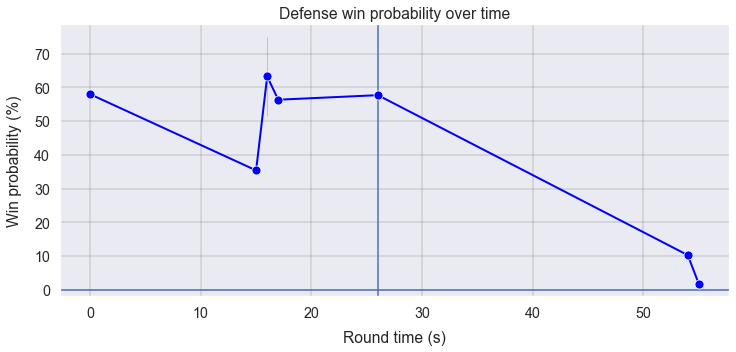

In [39]:
rr = RoundReplay(match)
rr.plot_round(8, side="def")

In [36]:
rr.get_plant_stamp(6)

54.0

In [37]:
rr.get_round_dataframe(6)

,RoundID,RoundNumber,RoundTime,ATK_wealth,DEF_wealth,ATK_alive,DEF_alive,DEF_has_OP,Def_has_Odin,RegularTime,SpikeTime,MapName,MatchID,SeriesID,bestOF,FinalWinner
44,414301,6,0,2640.0,3320.0,5,5,1,0,0,0,Split,26423,13188,3,1
45,414301,6,14508,2640.0,2740.0,5,4,1,0,15,0,Split,26423,13188,3,1
46,414301,6,15567,2320.0,2740.0,4,4,1,0,16,0,Split,26423,13188,3,1
47,414301,6,15798,1740.0,2740.0,3,4,1,0,16,0,Split,26423,13188,3,1
48,414301,6,16989,1740.0,2160.0,3,3,1,0,17,0,Split,26423,13188,3,1
49,414301,6,26026,1740.0,2160.0,3,3,1,0,26,0,Split,26423,13188,3,1
50,414301,6,54271,1740.0,1160.0,3,2,0,0,0,28,Split,26423,13188,3,1
51,414301,6,54836,1740.0,580.0,3,1,0,0,0,29,Split,26423,13188,3,1


https://runitback.gg/series/12745?match=25645&round=19&tab=replay